In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from IPython.display import display

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import glob
import sys
import joblib
sys.path.insert(-1,'../Tools')
from data_parser_new import parse
from data_analysis import df_vcg_vector, calc_cost, calc_cost_rms, calc_cost_rms_norm
from data_modification import calc_cost_patient, normalize_patient, trim_tat_patient, resample_patient, scale_at_patient

In [2]:
data_path = '../Data/New_Simulations/'
patients = [
            parse(initial_path=data_path, patient_number=patient_no, at_map = True, verbose = False) 
        #for patient_no in [6]
        for patient_no in range(0,8)
]

In [3]:
num_samples = 100
patients = [normalize_patient(patient) for patient in patients]
patients = [trim_tat_patient(patient) for patient in patients]
patients = [resample_patient(patient, length=num_samples) for patient in patients]
patients = [scale_at_patient(patient, length=num_samples) for patient in patients]

In [4]:
pt_opt_theta = {'BiV7': 54, 'BiV8': 54, 'BiV6': 70, 'BiV1': 144, 'BiV4': 59, 'BiV3': 37, 'BiV2': 55, 'BiV5': 88}

In [5]:
fdir = pwd
theta = np.zeros(8)
rms = np.zeros(8)

In [6]:
def plot_vcgs(labels, vcg1, vcg2=None, vcg3=None, ref_lines=False, arrows=False, title=False, alt_lines=False):
    """Split a vectorized VCG with a single function call

    Arguments
    ---------
    vcg1 : list
        A list containing the x,y, and z components
        of a vcg (i.e. [vcg_x,vcg_y,vcg_z])

    vcg2 : list
        A list containing the x,y, and z components
        of a vcg (i.e. [vcg_x,vcg_y,vcg_z])

    labels : list
        A list containing the labels for plotting

    Returns
    -------
    vcg_x,vcg_y,vcg_z : numpy.array
        The seperated vcg components
    """

    # sns.reset_orig()
    fig = plt.figure(figsize=(9, 9))
    fig.patch.set_facecolor('white')
    ax1 = plt.subplot2grid((12, 12), (1, 0), colspan=7, rowspan=2)
    ax2 = plt.subplot2grid((12, 12), (3, 0), colspan=7, rowspan=2)
    ax3 = plt.subplot2grid((12, 12), (5, 0), colspan=7, rowspan=2)
    ax4 = plt.subplot2grid((12, 12), (7, 0), colspan=7, rowspan=2)
    ax5 = plt.subplot2grid((12, 12), (0, 8), colspan=4, rowspan=4)
    ax6 = plt.subplot2grid((12, 12), (4, 8), colspan=4, rowspan=4)
    ax7 = plt.subplot2grid((12, 12), (8, 8), colspan=4, rowspan=4)
    ax8 = plt.subplot2grid((12, 12), (9, 2), colspan=4, rowspan=3)

    # p_txt = fig.text(0.35,.89,f.split('/')[-1], fontsize = 16, ha='center')
    if title:
        fig.suptitle(title, fontsize=18,fontweight='bold')

    t = np.arange(len(vcg1['VCGx']))

    ax1.plot(t, vcg1['VCGx'], 'k-',linewidth='0.5')
    if ref_lines: ax1.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax1.set_title('X',x=0,y=0.8, fontsize=16)
    ax1.axis('off')

    ax2.plot(t, vcg1['VCGy'], 'k-',linewidth='0.5')
    if ref_lines: ax2.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax2.set_title('Y',x=0,y=0.8, fontsize=16)
    ax2.axis('off')

    ax3.plot(t, vcg1['VCGz'], 'k-',linewidth='0.5')
    if ref_lines: ax3.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax3.set_title('Z', x=0, y=0.8, fontsize=16)
    ax3.axis('off')

    ax4.plot(t, np.linalg.norm(vcg1, axis=1), 'k-',linewidth='0.5', label=labels[0])
    ax4.set_title('Mag.', x=-0.05, y=0.5, fontsize=16)
    ax4.set_xlabel('Time (ms)', fontsize=16)
    # ax4.axis('off')
    ax4.spines['right'].set_color('none')
    ax4.spines['left'].set_color('none')
    ax4.axes.get_yaxis().set_visible(False)
    ax4.spines['top'].set_color('none')
    ax4.set_facecolor('w')

    lines = []  # gather lines to add arrows if needed
    lines.append(ax5.plot(vcg1['VCGx'], vcg1['VCGz']*-1, 'k-'))
    ax5.set_title('Transverse', fontsize=16)
    ax5.axis('equal')
    ax5.set_facecolor('w')

    lines.append(ax6.plot(vcg1['VCGx'], vcg1['VCGy']*-1, 'k-'))
    ax6.set_title('Frontal', fontsize=16)
    ax6.axis('equal')
    ax6.set_facecolor('w')

    lines.append(ax7.plot(vcg1['VCGz']*-1, vcg1['VCGy']*-1, 'k-'))
    ax7.set_title('Left Sagittal', fontsize=16)
    ax7.axis('equal')
    ax7.set_facecolor('w')

    for ax in [ax5, ax6, ax7]:
        for axis in ['top', 'right']:
            ax.spines[axis].set_color('none')
        for axis in ['left', 'bottom']:
            if ref_lines:
                ax.spines[axis].set_position('center')
                ax.spines[axis].set_color('0.5')
                ax.spines[axis].set_linewidth(1.0)
                ax.set_yticks([])
                ax.set_xticks([])
                # plt.text(axmax,0-0.05,'X', color='0.5',size='xx-small')
                # plt.text(0-0.05,-axmax-0.11,'Y', color='0.5',size='xx-small')
            else:
                ax.spines[axis].set_color('none')
                ax.set_yticks([])
                ax.set_xticks([])

    ax8.axis('off')

    if alt_lines:
        line_style = alt_lines
    else:
        line_style = ['b-','r-']

    if isinstance(vcg2, pd.DataFrame):
        t_vcg = np.arange(len(vcg2['VCGx']))
        ax1.plot(t_vcg, vcg2['VCGx'], line_style[0])
        ax2.plot(t_vcg, vcg2['VCGy'], line_style[0])
        ax3.plot(t_vcg, vcg2['VCGz'], line_style[0])
        ax4.plot(t_vcg, np.linalg.norm(vcg2, axis=1), line_style[0], label=labels[1])
        lines.append(ax5.plot(vcg2['VCGx'], vcg2['VCGz']*-1, line_style[0]))
        lines.append(ax6.plot(vcg2['VCGx'], vcg2['VCGy']*-1, line_style[0]))
        lines.append(ax7.plot(vcg2['VCGz']*-1, vcg2['VCGy']*-1, line_style[0]))
    if isinstance(vcg3, pd.DataFrame):
        t_vcg = np.arange(len(vcg3['VCGx']))
        ax1.plot(t_vcg, vcg3['VCGx'], line_style[1])
        ax2.plot(t_vcg, vcg3['VCGy'], line_style[1])
        ax3.plot(t_vcg, vcg3['VCGz'], line_style[1])
        ax4.plot(t_vcg, np.linalg.norm(vcg3, axis=1), line_style[1], label=labels[2])
        lines.append(ax5.plot(vcg3['VCGx'], vcg3['VCGz']*-1, line_style[1]))
        lines.append(ax6.plot(vcg3['VCGx'], vcg3['VCGy']*-1, line_style[1]))
        lines.append(ax7.plot(vcg3['VCGz']*-1, vcg3['VCGy']*-1, line_style[1]))

    ax4.legend(prop={'size': 16}, frameon=False, bbox_to_anchor=(1.0, -0.5))

BiV2


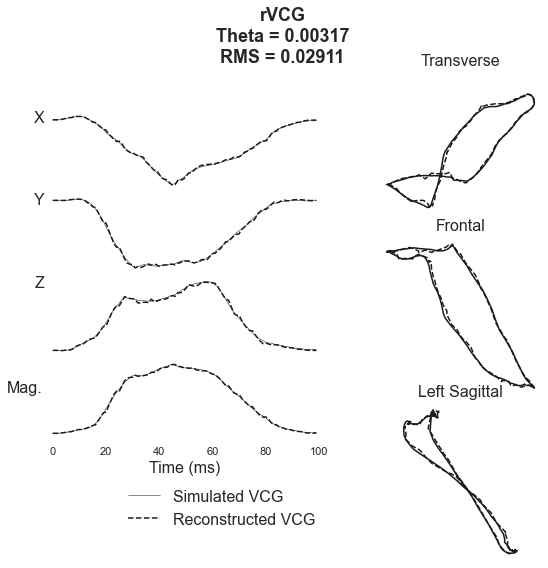

In [11]:
# BiV2
i = 6
patient = patients[i]
print(patient['pt_id'])
i_opt = pt_opt_theta[patient['pt_id']]

rVCG_shift_file = fdir+'VCG_BiV2_sim056_shift1_rVCG.txt'
BiV2_rVCG = pd.read_csv(rVCG_shift_file, header=None, usecols=[2, 3, 4], names=['VCGx', 'VCGy', 'VCGz'], sep='\t', index_col=False)
BiV2_rVCG.drop(BiV2_rVCG.tail(25).index,inplace = True)


vcg_sim_norm = patient['vcg_model'][i_opt] / np.linalg.norm(patient['vcg_model'][i_opt],axis=1).max()
vcg_rVCG_norm = BiV2_rVCG / np.linalg.norm(BiV2_rVCG,axis=1).max()

theta[i] = calc_cost(vcg_sim_norm,vcg_rVCG_norm)
rms[i]  = calc_cost_rms(vcg_sim_norm,vcg_rVCG_norm)

plot_vcgs(['Simulated VCG','Reconstructed VCG'],vcg_sim_norm,vcg_rVCG_norm,
          ref_lines=False,arrows=True, alt_lines = ['k--'],
          title = 'rVCG\nTheta = %.5f\nRMS = %.5f'%(theta[i],rms[i]))
plt.savefig('Fig4A.pdf', transparent=True)